In [1]:
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import pystrum
# import neurite as ne
from monai.losses import (
    GlobalMutualInformationLoss,
    BendingEnergyLoss,
    DiffusionLoss)
from monai.transforms import BorderPad
from utils import *

2024-07-29 14:58:36.288858: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 14:58:36.319373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:58:36.354396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:58:36.365046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 14:58:36.389989: I tensorflow/core/platform/cpu_feature_guar

In [2]:
grid = pystrum.pynd.ndutils.bw_grid(vol_shape=(100, 100), spacing=11)

In [3]:
angle = np.pi/8 * np.random.uniform(-1/2, 1/2)
transform = torch.Tensor( [[[0.99*np.cos(angle), -np.sin(angle), 0.1],
                           [np.sin(angle), 0.9*np.cos(angle), 0.06]]])
b, c, w, h = 1, 1, 200, 200
warping = F.affine_grid(transform, size=(b, c, h, w), align_corners=True)
warped = F.grid_sample(torch.Tensor(grid)[None, None], warping, mode="bilinear", align_corners=True)


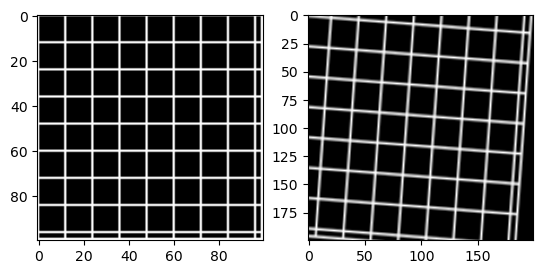

In [4]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(grid, cmap="gray")
ax[1].imshow(warped[0,0], cmap="gray")
plt.show()

### Classical image Registration

In [5]:
# Toy data
n = 224
x = torch.arange(n)
y = torch.arange(n)

sigmax = 1.5
sigmay = 3
X1 = (x-n/2) / (sigmax*np.sqrt(n))
X2 = (x-n/4) / (sigmay*np.sqrt(n)) 
Y1 = (y-n/2) / (sigmay*np.sqrt(n))
Y2 = (y-n/2) / (sigmax*np.sqrt(n))

I = torch.exp(-X1.view(1, n)**2-Y1.view(n, 1)**2) + torch.exp(-X2.view(1, n)**2-Y2.view(n, 1)**2)
image = I.view(1, 1, n, n)

In [6]:
img = plt.imread("brain.jpg")
img = img[::3,::3]
img = img[None,None]
img = torch.Tensor(img)
# img = image
transform = BorderPad(spatial_border=[0, 0, 50])
img = transform(img)

/tmp/ipykernel_75878/887575911.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.Tensor(img)


In [7]:
img.shape

torch.Size([1, 1, 429, 500])

In [8]:
# transform = BorderPad(spatial_border=[0, 10, 10])
# img = transform(img)


In [9]:
angle = np.pi/4 * np.random.uniform(-1, 1)
rot = Deformation(angle=angle, dx=0.1, dy=0.0)
m_image, _ = rot(img)

# m_image = transform(m_image)

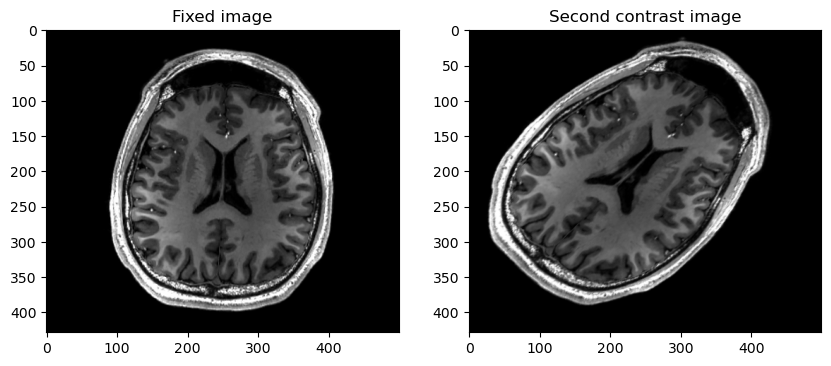

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img[0, 0], cmap="gray")
# ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(m_image[0, 0].detach().numpy(), cmap="gray")
# ax[1].axis('off')
ax[1].set_title("Second contrast image")
plt.show()

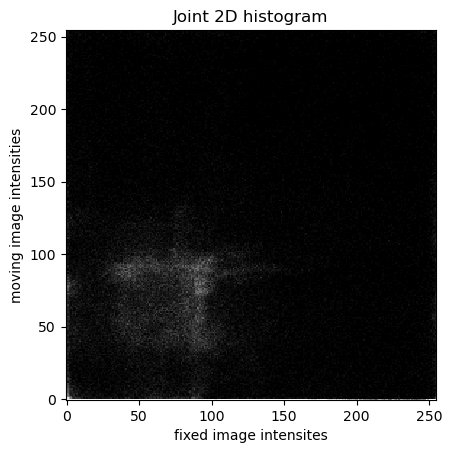

In [11]:
x = img.ravel()
y = m_image.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.title("Joint 2D histogram")
plt.xlabel("fixed image intensites")
plt.ylabel("moving image intensities")
plt.show()

In [14]:
reg = AffineRegistration()
m_image, _ = rot(img)
pred, _ = reg(m_image)
m_image = m_image.detach()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-2)
criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
# criterion = GlobalMutualInformationLoss(kernel_type="b-spline")

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


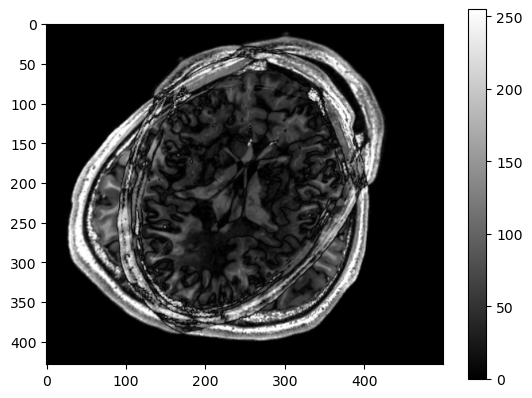

In [15]:
plt.imshow(torch.abs(img-m_image)[0, 0], cmap="gray")
plt.imshow(torch.abs(img[0,0] - m_image[0,0]), cmap="gray")
plt.colorbar()

In [16]:
def dice_loss(x, y):
    return 1 - (((2*x*y).sum()+1e-3) / (x.sum() + y.sum()+1e-3)) 
energy_loss = BendingEnergyLoss()

In [17]:
N_ITER = 400
losses = []
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(m_image) #.requires_grad_(True)
    loss = criterion(pred, img) #+ dice_loss(pred, img) #GlobalMutualInformationLoss()(pred, img)
    # loss+= energy_loss(ddf.permute(0, -1, 1, 2)) #dice_loss(pred, img) 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 400/400 [00:07<00:00, 53.89it/s]


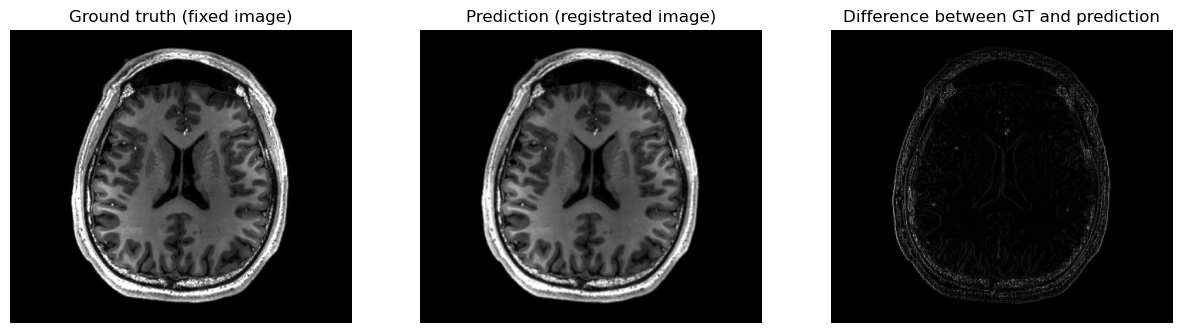

In [18]:
pred, _ = reg(m_image)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Ground truth (fixed image)")
ax[1].imshow(pred[0, 0].detach(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("Prediction (registrated image)")
ax[2].imshow(torch.abs(img-pred.detach())[0, 0], cmap="gray")
ax[2].axis('off')
ax[2].set_title("Difference between GT and prediction")
plt.show()

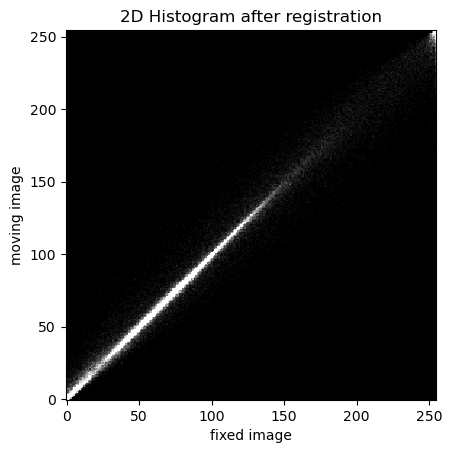

In [19]:
x = img.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, ls="", marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
plt.title("2D Histogram after registration")
plt.xlabel("fixed image")
plt.ylabel("moving image")
plt.show()

In [20]:
print("Absolute error : {:.3f}".format(float(torch.abs(img-pred.detach()).mean() / torch.abs(img).mean())))

Absolute error : 0.049


In [23]:
t = rot.affine_transform
tinv = list(reg.parameters())[0].data
T = torch.eye(3)
Tinv = torch.eye(3)
 
Tinv[:2] = tinv
T[:2] = t

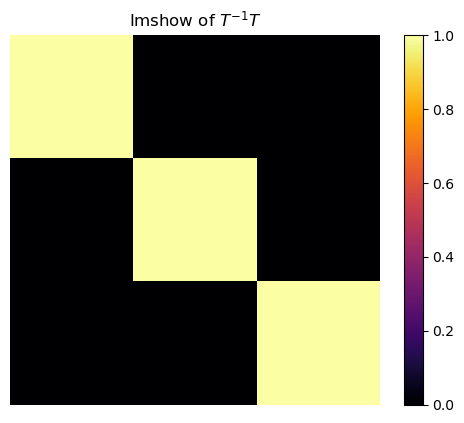

In [24]:
plt.imshow(Tinv@T, cmap="inferno")
plt.title("Imshow of $T^{-1}T$")
plt.axis("off")
plt.colorbar()
plt.show()

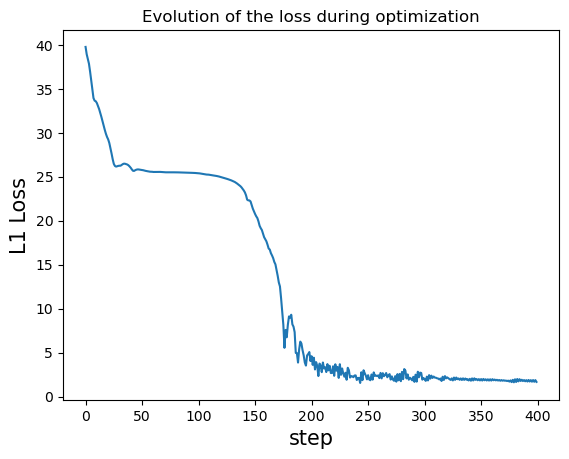

In [26]:
plt.plot(losses)
plt.title("Evolution of the loss during optimization")
plt.xlabel("step", fontsize=15)
plt.ylabel("L1 Loss", fontsize=15)
plt.show()

In [27]:
img = plt.imread("brain.jpg")
img = img[::3,::3]
img = img[None,None]
img = torch.Tensor(img)
transform = BorderPad(spatial_border=[0, 0, 50])
img = transform(img)

angle = np.pi/8 * np.random.uniform(-1, 1)
rot = Deformation(angle=angle, dx=0.2, dy=0.0)
m_image, _ = rot(img)
m_image = m_image

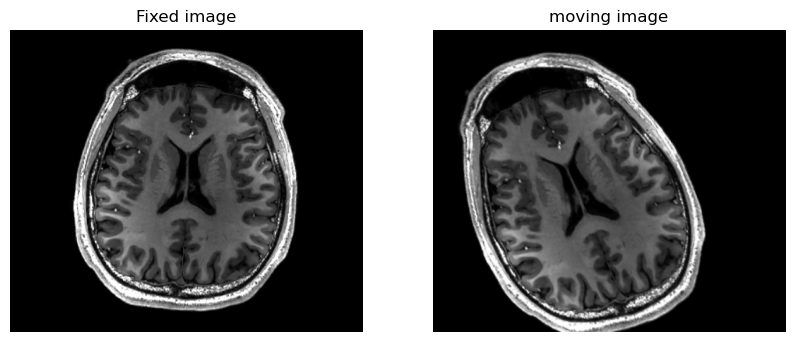

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Fixed image")
ax[1].imshow(m_image[0, 0].detach().numpy(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("moving image")
plt.show()

In [36]:
reg = AffineRegistration()
m_image, _ = rot(img)
m_image= m_image
pred, _ = reg(m_image)
m_image = m_image.detach()
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-2)
criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
# criterion = GlobalMutualInformationLoss(kernel_type="b-spline")

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


Text(0, 0.5, 'Moving image intensity')

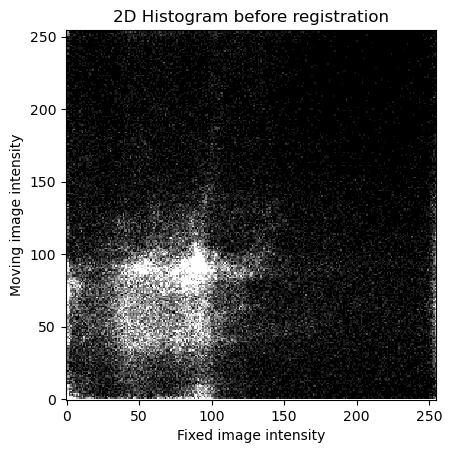

In [37]:
x = img.ravel()
y = m_image.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram before registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Moving image intensity")

In [38]:
N_ITER = 400
losses = []
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(m_image) #.requires_grad_(True)
    loss = criterion(pred, img) #+ dice_loss(pred, img) #GlobalMutualInformationLoss()(pred, img)
    # loss+= energy_loss(ddf.permute(0, -1, 1, 2)) #dice_loss(pred, img) 
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 400/400 [00:07<00:00, 55.17it/s]


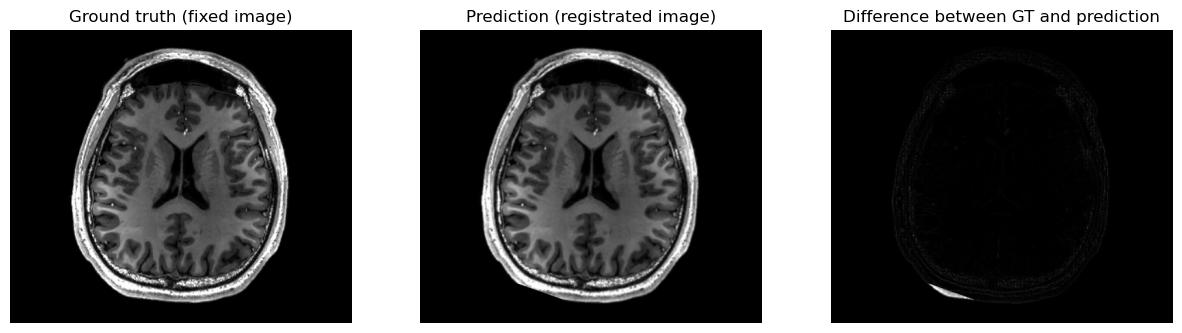

In [39]:
pred, _ = reg(m_image)
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(img[0, 0], cmap="gray")
ax[0].axis('off')
ax[0].set_title("Ground truth (fixed image)")
ax[1].imshow(pred[0, 0].detach(), cmap="gray")
ax[1].axis('off')
ax[1].set_title("Prediction (registrated image)")
ax[2].imshow(torch.abs(img-pred.detach())[0, 0], cmap="gray")
ax[2].axis('off')
ax[2].set_title("Difference between GT and prediction")
plt.show()

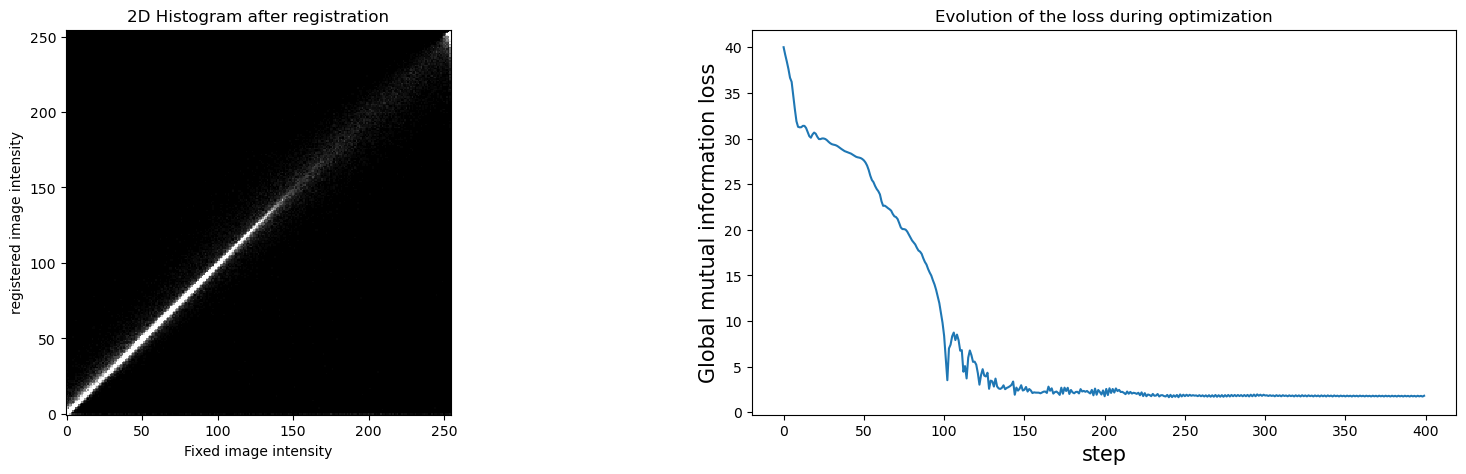

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
x = img.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, ls="", marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
ax[0].imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=50)
ax[0].set_title("2D Histogram after registration")
ax[0].set_xlabel("Fixed image intensity")
ax[0].set_ylabel("registered image intensity")
ax[1].plot(losses)
ax[1].set_title("Evolution of the loss during optimization")
ax[1].set_xlabel("step", fontsize=15)
ax[1].set_ylabel("L1 Loss", fontsize=15)
plt.show()

### Multimodal registration by Mutual Information maximization

In [33]:
t1_img = nib.load("../mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz")
t1_data = t1_img.get_fdata()
t2_img = nib.load("../mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a.nii.gz")
t2_data = t2_img.get_fdata() 

In [35]:
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
transform = BorderPad(spatial_border=[0, 20, 20])
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
# transform = BorderPad(spatial_border=[0, 20, 20])
t1_slice.shape

(197, 233)

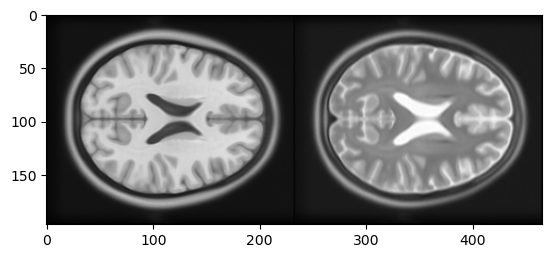

In [44]:
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)), cmap="gray")
plt.show()
t1_slice = torch.Tensor(t1_slice[None, None])
t2_slice = torch.Tensor(t2_slice[None, None])


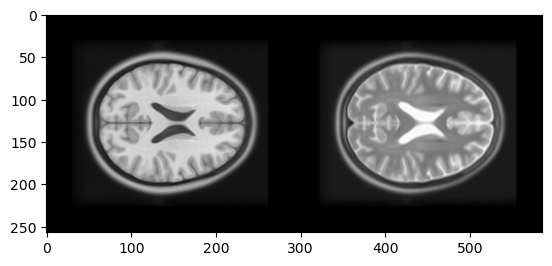

In [45]:
transform = BorderPad(spatial_border=[0, 30, 30])
t1_slice = transform(t1_slice)
t2_slice = transform(t2_slice)
plt.imshow(np.hstack((t1_slice[0,0], t2_slice[0,0])), cmap="gray")
plt.show()

In [ ]:
x = t1_slice.ravel()
y = t2_slice.ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()

In [55]:
N_ITER = 500
reg = Deformation(angle=None)
optimizer = torch.optim.Adam(params=reg.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss() #
criterion = torch.nn.MSELoss()
criterion = GlobalMutualInformationLoss(kernel_type="b-spline")
diffusion_loss = DiffusionLoss()

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 1., 0.]]], requires_grad=True)


In [56]:
t1_slice.shape

torch.Size([1, 1, 257, 293])

In [57]:
angle = np.pi/6
a, b = np.cos(angle), np.sin(angle)
transform = torch.Tensor( [[[a, -b, 0.1],
                           [b, a, 0.0]]])
warping = F.affine_grid(transform, size=t1_slice.shape, align_corners=True)
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)

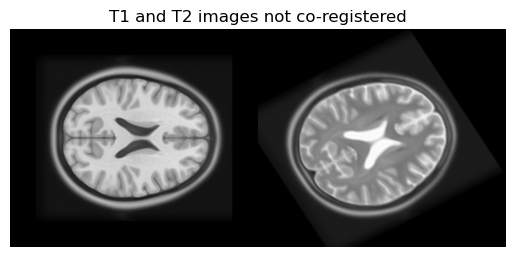

In [59]:
t1_slice.shape
t2_m = F.grid_sample(t2_slice, warping, mode="bilinear", align_corners=True)
t2_m = t2_m.detach()
plt.imshow(np.hstack((t1_slice[0,0], t2_m[0,0])), cmap="gray")
plt.axis("off")
plt.title("T1 and T2 images not co-registered")
plt.show()

In [60]:
losses = []
# best_loss = torch.inf
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    pred, ddf = reg(t2_m) #.requires_grad_(True)
    loss = criterion(pred, t1_slice) #dice_loss(pred, img) 
    # loss += diffusion_loss(ddf.permute(0, -1, 1, 2))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 500/500 [00:48<00:00, 10.42it/s]


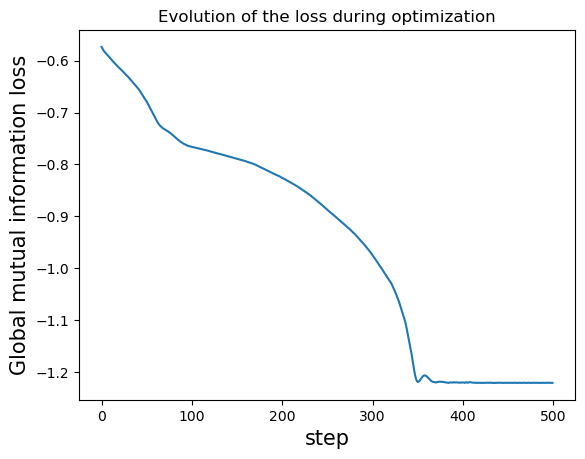

In [65]:
plt.plot(losses)
plt.title("Evolution of the loss during optimization")
plt.xlabel("step", fontsize=15)
plt.ylabel("Global mutual information loss", fontsize=15)
plt.show()

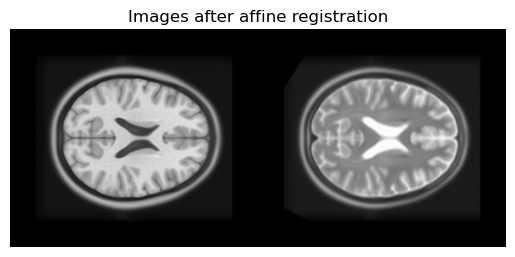

In [63]:
plt.imshow(np.hstack((t1_slice[0,0], pred.detach().numpy()[0,0])), cmap="gray")
plt.axis("off")
plt.title("Images after affine registration")
plt.show()

Text(0, 0.5, 'Moving image intensity')

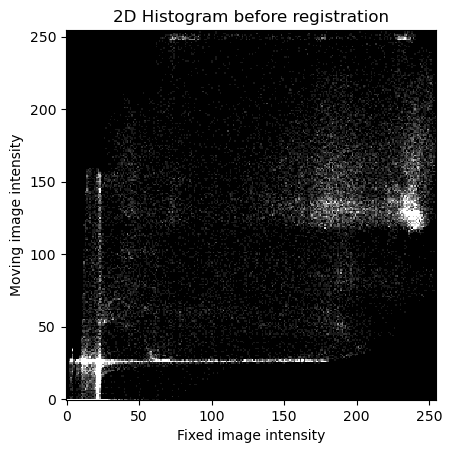

In [67]:
x = t1_slice.ravel()
y = t2_m.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram before registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Moving image intensity")

Text(0, 0.5, 'Registered image intensity')

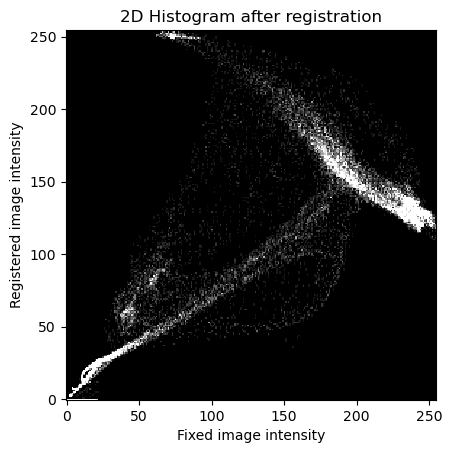

In [68]:
x = t1_slice.ravel()
y = pred.detach().ravel()
# plt.plot(x, y, marker="o", alpha=0.1)
# plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=10)
plt.title("2D Histogram after registration")
plt.xlabel("Fixed image intensity")
plt.ylabel("Registered image intensity")

In [187]:
print(list(reg.parameters()))

[Parameter containing:
tensor([[[ 8.6675e-01,  5.0103e-01, -2.8199e-05],
         [-5.0000e-01,  8.6855e-01, -9.2042e-05]]], requires_grad=True)]


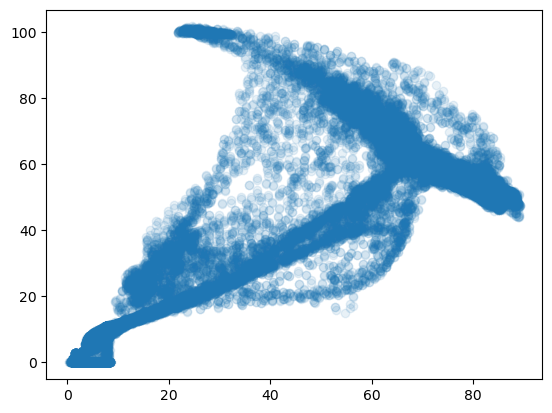

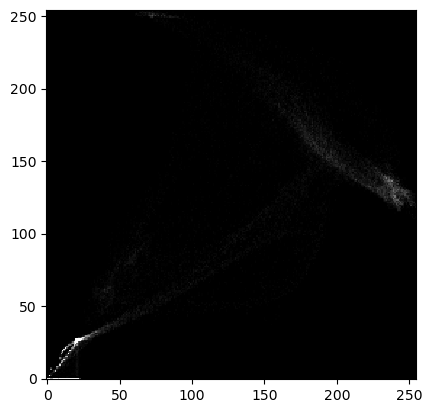

In [188]:
x = t1_slice.ravel()
y = pred.detach().ravel()
plt.plot(x, y, ls="", marker="o", alpha=0.1)
plt.show()
hist, xedges, yedges = np.histogram2d(x, y, bins=255)
plt.imshow(hist.T, cmap="gray", origin='lower', interpolation='nearest', vmin=0, vmax=100)
plt.show()